In [1]:
### using (7.60a), which f0*\bar{v} - d(\bar{u'v'})/dy equal m 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# read variables
from scipy.fftpack import fft,ifft,fftfreq
file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

In [4]:
# The edition without time mean
# WARNING: ############### mean I delete the zonal mean, in order to get (500,64)
def plot_V_W_50(pr):
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    dycore = Dycore(file)
    
    # u  = dycore.getVar("grid_u_c_xyzt")
    v     = dycore.getVar("grid_v_c_xyzt")
    t     = dycore.getVar("grid_t_c_xyzt")
    ps    = dycore.getVar("grid_ps_xyzt")
    p     = dycore.getVar("grid_p_full_xyzt")
    Rd    = 287
    cp    = 1004
    g     = 9.81
    theta = t * (ps / p)**(Rd/cp)
    H     = 6800
    a     = 6.37122e6
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(((500,20,64)))
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:] = np.nanmean(p[:,i,:,:], axis=2) / np.nanmean(ps[:,0,:,:], axis=2)                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzm = np.nanmean(theta, axis=(3)) ######################
    THETAz  = np.zeros(((500,20,64))) ############ 
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[:,i,:] = (THzm[:,i+1,:] - THzm[:,i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1]) #########
    THETAz[:,0,:]  = (THzm[:,1,:]  - THzm[:,0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[:,-1,:] = (THzm[:,-1,:] - THzm[:,-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    # VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzm = np.nanmean(v, axis=(3)) #########
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0_all * VTHzm / THETAz ############################################
    vTEM_tempdz = np.zeros(((500,20,64)))
    for i in range(1,19):
        vTEM_tempdz[:,i,:] = (vTEM_temp[:,i+1,:] - vTEM_temp[:,i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[:,0,:]  = (vTEM_temp[:,1,:]  - vTEM_temp[:,0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[:,-1,:] = (vTEM_temp[:,-1,:] - vTEM_temp[:,-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzm #################
    vTEM2 = (1/rho_0_all) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzm / THETAz ############################################
    wTEM_tempdphi = np.zeros(((500,20,64)))
    for i in range(1,63):
        wTEM_tempdphi[:,:,i] = (wTEM_temp[:,:,i+1] - wTEM_temp[:,:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,:,0]  = (wTEM_temp[:,:,1] - wTEM_temp[:,:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,:,-1] = (wTEM_temp[:,:,-1] - wTEM_temp[:,:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzm ##################
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0
vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)
print("over")


over


In [5]:
print(vTEM.shape)
# cal zonal mean and zonal anamoly
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  

(500, 20, 64)


In [6]:
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

30.523438099781337
(500,)
1.0


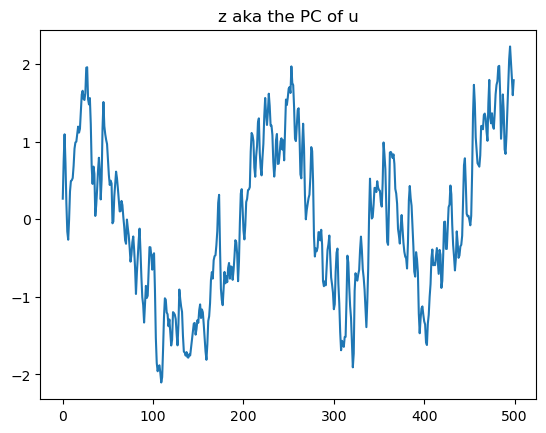

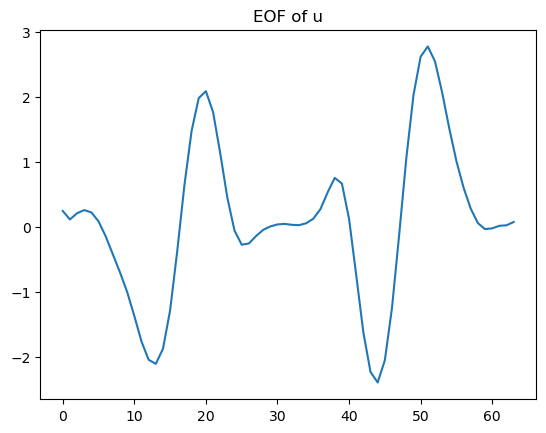

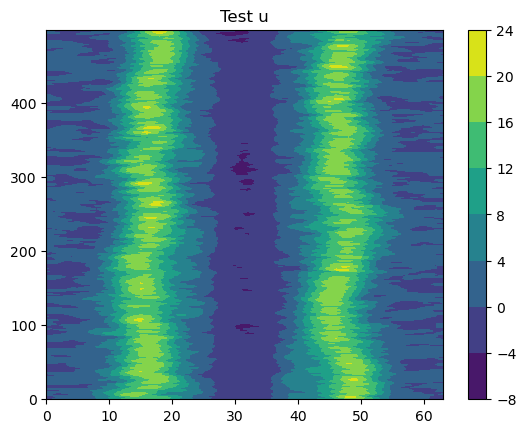

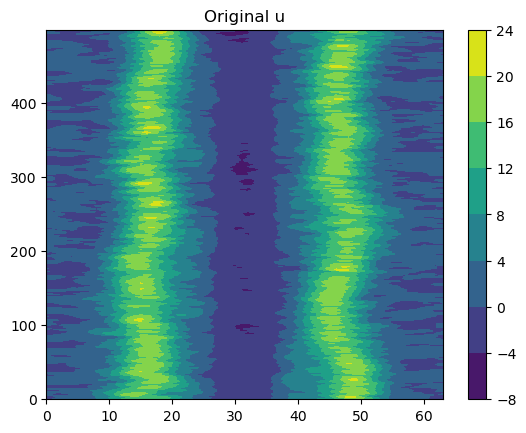

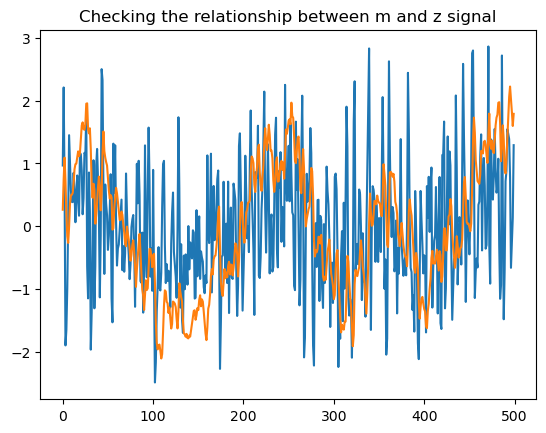

In [7]:
# Before EOF, we need to normalize final_m_term
from EOF import EOF
from scipy.fft import fft, ifft

u_50 = dycore.getVar("grid_u_c_xyzt")
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    u_50[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50 = np.nanmean(u_50[:,:,:,:], axis=(1,3))

single_EOF_50 =  EOF((u_50[:,:],), n_components=64, field="1D")
single_EOF_50.get()

z       = (single_EOF_50.PC[0,:])
EOF_try = (single_EOF_50.EOF[0,:])

z_std   = z.std()
z       = z / z_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

plt.figure()
plt.plot(z)
plt.title("z aka the PC of u") 


EOF_std = EOF_try.std()
EOF_try = EOF_try * z_std 
plt.figure()
plt.plot(EOF_try)
plt.title("EOF of u") 

print(np.nanmax(vTEM))

# do (7.60a) eq
v = dycore.getVar("grid_v_c_xyzt")
u = dycore.getVar("grid_u_c_xyzt")

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

f0 = 2 * 7.292E-5 * np.sin(yd)
v_zonal = np.nanmean(v, axis=(1,3))
v_bar   = v_zonal # [:,10,:]

Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm

momentum_with_level = np.nanmean(Uza * Vza, axis=(1,3))
momentum = momentum_with_level #[:,10,:]
for i in range(1,64-1):
    momentum[:,i] = cy[i]**0.5 * momentum[:,i]

dmdy = np.zeros((500,64))
for i in range(1,64-1):
    dmdy[:,i] = (momentum[:,i+1] - momentum[:,i-1]) / (yd[i+1] - yd[i-1])
dmdy[:, 0] = (momentum[:, 1] - momentum[:, 0]) / (yd[ 1] - yd[ 0])
dmdy[:,-1] = (momentum[:,-1] - momentum[:,-2]) / (yd[-1] - yd[-2])

final_7_60_a  = f0 * v_bar - dmdy
final_7_60_a2 = np.zeros((500,64))
for i in range(500):
    final_7_60_a2[i,:] = final_7_60_a[i,:] - np.nanmean(final_7_60_a, axis=0)
#######################################################################
m = np.dot(EOF_try[2:-2], final_7_60_a2[:,2:-2].T)
print(m.shape)
# m = m * 30 * 86400 /np.pi
m_std = m.std()
m = m / m_std
print(np.std(m))
plt.figure()
CS1 = plt.contourf((single_EOF_50.EOF.T.dot(single_EOF_50.PC)).T)
plt.title("Test u") 
plt.colorbar(CS1)

plt.figure()
CS2 = plt.contourf(u_50)
plt.title("Original u") 
plt.colorbar(CS2)


plt.figure()
plt.title("Checking the relationship between m and z signal") 
plt.plot(m)
plt.plot(z)


(0.034482112462651184+0.04420100969494794j)
(0.03835754028503873+0.03537251507871978j)
[ 0.1092803 +0.j          0.38855829+0.82673507j  0.3838862 +2.22620616j
  0.37704051+5.4657238j  -0.69487304+3.41277328j -0.71934971+5.63257143j
  7.26415259+1.72147139j  1.5464863 +5.60466433j -4.99960803+6.86309898j
  1.7714301 -2.6776327j  -4.27529708+0.j          1.7714301 +2.6776327j
 -4.99960803-6.86309898j  1.5464863 -5.60466433j  7.26415259-1.72147139j
 -0.71934971-5.63257143j -0.69487304-3.41277328j  0.37704051-5.4657238j
  0.3838862 -2.22620616j  0.38855829-0.82673507j]


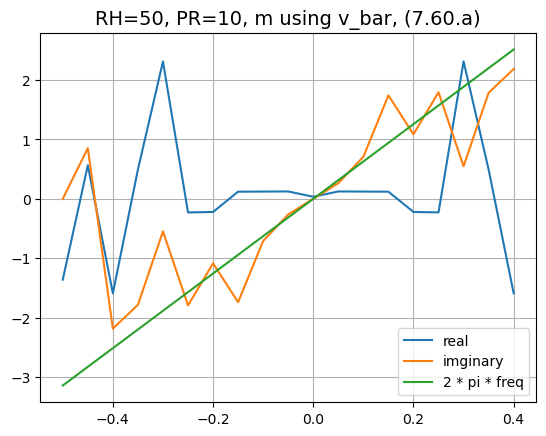

In [8]:
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 20 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z[0:aa+lg])  / len(z[0:aa+lg])     #要除以資料長度
        M_sum += fft(m[0:aa+lg])  / len(m[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z[aa:aa+lg]) / len(z[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m[aa:aa+lg]) / len(m[aa:aa+lg])
        # print(np.nanmin(Z_sum))
    
# print((len(Z) / lg))
Z = Z_sum / (len(z) / lg)
M = M_sum / (len(m) / lg)
print(np.nanmax(Z))
print(np.nanmax(M))
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
print(final)
plt.figure(dpi=100.)
plt.title("RH=50, PR=10, m using v_bar, (7.60.a)", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.01, 0.25])
# plt.ylim([-0.05,1.75])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.60a)_fiEMF and EMF relatedg/RH50_PR10//cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()

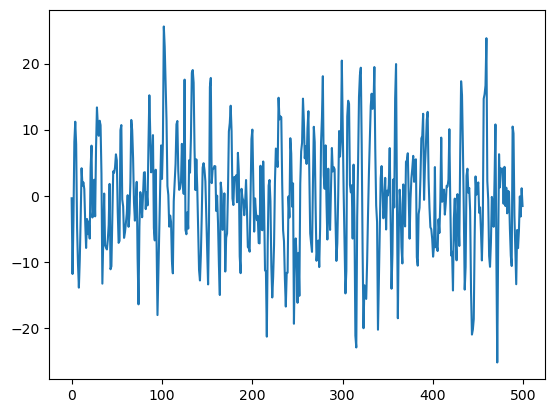

In [33]:
v = dycore.getVar("grid_v_c_xyzt")
p = dycore.getVar("grid_p_full_xyzt")
v_vertical = np.zeros((((500,20,64,128))))
for i in range(1,20-1):
    v_vertical[:,i,:,:] += v[:,i,:,:] * (p[:,i+1,:,:] - p[:,i-1,:,:]) / 9.81
v_vertical[:,0,:,:]  += v[:,0,:,:] * (p[:,1,:,:] - p[:,0,:,:]) / 9.81
v_vertical[:,-1,:,:] += v[:,-1,:,:] * (p[:,-1,:,:] - p[:,-2,:,:]) / 9.81
v_vertical = np.nanmean(v_vertical, axis=(1,3))
plt.figure()
plt.plot(np.nanmean(v_vertical[:,:], axis=1))


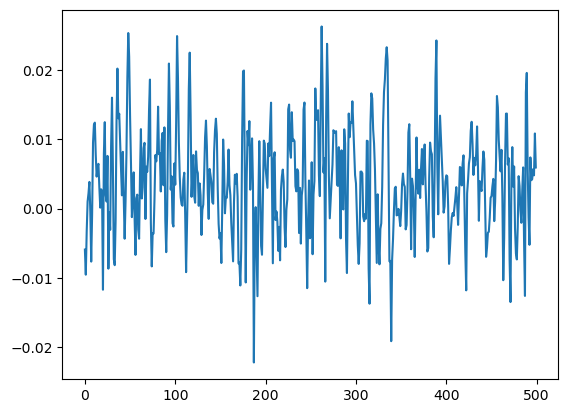

In [49]:
v_new = np.zeros(v.shape)
for i in range(64):
    v_new[:,:,i,:] = v[:,:,i,:] * np.cos(yd[i])**0.5
vv = np.nanmean(v_new, axis=(1,3))
plt.figure(dpi=100.)
plt.plot(vv[:,-5])
# plt.xlabel('longitude')
# plt.ylabel('time')
